In [1]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
#from Functions import prep_training_test_data_period, prep_training_test_data, calculate_ppv_npv
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


In [2]:
def prep_training_test_data_period(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    y_weeks_to_check = []  # check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        for week_y in range(week + 1, test_week + 1):
            y_weeks_to_check.append("_" + num2words(week_y) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    ## Divide up the test/train split
    # if is_geographic:
    # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
    # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1

        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
        train_week = w2n.word_to_num(x_week.replace("_", ""))
        target_week = w2n.word_to_num(y_week.replace("_", ""))
        y_weeks_to_check = []
        for week_to_check in range(train_week + 1, target_week + 1):
            y_weeks_to_check.append("_" + num2words(week_to_check) + "_")

        y_weeks_to_check = [week + "beds_over_15_100k" for week in y_weeks_to_check]
        columns_to_check = [
            col for col in data.columns if any(week in col for week in y_weeks_to_check)
        ]
        y_over_in_period = data[columns_to_check].apply(max, axis=1)
        data_y = pd.concat([data_y, y_over_in_period], axis=1)
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

        y_week.columns = range(1, len(data_y.columns) - 2)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)

def prep_training_test_data(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1
        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

            # rename columns for concatenation
        y_week.columns = range(1, len(data_y.columns) - 1)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)



def prep_training_test_data_shifted(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    y_weeks_to_check = []  # check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        for week_y in range(week + 2, test_week + 2):
            y_weeks_to_check.append("_" + num2words(week_y) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")
    ## Divide up the test/train split
    # if is_geographic:
    # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
    # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1

        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
        train_week = w2n.word_to_num(x_week.replace("_", ""))
        target_week = w2n.word_to_num(y_week.replace("_", ""))
        y_weeks_to_check = []
        for week_to_check in range(
            train_week + 2, target_week + 2
        ):  # have to ensure you skip the next week for getting the excess
            y_weeks_to_check.append("_" + num2words(week_to_check) + "_")
            print(y_weeks_to_check)
        y_weeks_to_check = [week + "beds_over_15_100k" for week in y_weeks_to_check]
        columns_to_check = [
            col for col in data.columns if any(week in col for week in y_weeks_to_check)
        ]
        y_over_in_period = data[columns_to_check].apply(max, axis=1)
        data_y = pd.concat([data_y, y_over_in_period], axis=1)
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)

        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

        y_week.columns = range(1, len(data_y.columns) - 2)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)


In [3]:
def cross_validation_leave_geo_out(data, geography_column, geo_split, no_iterations, cv, classifier, param_grid, no_iterations_param, no_weeks_train,no_weeks_test, weeks_in_future, weight_col, keep_output, time_period):
        best_hyperparameters_per_iter = []
        auROC_per_iter = []

        for i in range(no_iterations):
                #subset the HSAs from the full dataset 
                geo_names = data[geography_column].unique()
                num_names_to_select = int(geo_split * len(geo_names))
                geos_for_sample = random.sample(list(geo_names), num_names_to_select)
                subset_HSAs_for_train = data[data[geography_column].isin(geos_for_sample)]
                subset_HSAs_for_test = data[~data[geography_column].isin(geos_for_sample)]

                #create training and test data
                if time_period == 'period':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                elif time_period == 'exact':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col =weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                elif time_period == 'shifted':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                random_search = RandomizedSearchCV(classifier, param_grid, n_iter=no_iterations_param, cv=cv, random_state=10)
                random_search.fit(X_sample_train, y_sample_train, sample_weight = weights_train)
                best_params = random_search.best_params_

        # Create the Decision Tree classifier with the best hyperparameters
                model = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')
                model_fit = model.fit(X_sample_train, y_sample_train, sample_weight=weights_train)
                y_pred = model_fit.predict_proba(X_sample_test)
                # Evaluate the accuracy of the model
                best_hyperparameters_per_iter.append(best_params)
                auROC_per_iter.append(roc_auc_score(y_sample_test, y_pred[:,1]))
        
        return best_hyperparameters_per_iter[np.argmax(np.array(auROC_per_iter))]


# Get data

In [4]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

Naive Data

In [5]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

In [6]:
X_train_naive_period, y_train_naive_period, weights_naive_period, missing_data_train_HSA = prep_training_test_data_period(naive_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)
X_test_naive_period, y_test_naive_period, weights_test_naive_period, missing_data_test_HSA = prep_training_test_data_period(naive_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights_naive_period = weights_naive_period[0].to_numpy()

X_train_naive_exact, y_train_naive_exact, weights_naive_exact, missing_data_train_HSA = prep_training_test_data(naive_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)
X_test_naive_exact, y_test_naive_exact, weights_test_naive_exact, missing_data_test_HSA = prep_training_test_data(naive_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights_naive_exact = weights_naive_exact[0].to_numpy()


X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA_shifted = prep_training_test_data_shifted(naive_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test_naive_shifted, y_test_naive_shifted, weights_test_shifted, missing_data_test_HSA_shifted = prep_training_test_data_shifted(naive_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)

weights_shifted = weights_naive_shifted[0].to_numpy()


['_three_']
['_three_', '_four_']
['_three_', '_four_', '_five_']
['_four_']
['_four_', '_five_']
['_four_', '_five_', '_six_']
['_five_']
['_five_', '_six_']
['_five_', '_six_', '_seven_']
['_six_']
['_six_', '_seven_']
['_six_', '_seven_', '_eight_']
['_seven_']
['_seven_', '_eight_']
['_seven_', '_eight_', '_nine_']
['_eight_']
['_eight_', '_nine_']
['_eight_', '_nine_', '_ten_']
['_nine_']
['_nine_', '_ten_']
['_nine_', '_ten_', '_eleven_']
['_ten_']
['_ten_', '_eleven_']
['_ten_', '_eleven_', '_twelve_']
['_eleven_']
['_eleven_', '_twelve_']
['_eleven_', '_twelve_', '_thirteen_']
['_twelve_']
['_twelve_', '_thirteen_']
['_twelve_', '_thirteen_', '_fourteen_']
['_thirteen_']
['_thirteen_', '_fourteen_']
['_thirteen_', '_fourteen_', '_fifteen_']
['_fourteen_']
['_fourteen_', '_fifteen_']
['_fourteen_', '_fifteen_', '_sixteen_']
['_fifteen_']
['_fifteen_', '_sixteen_']
['_fifteen_', '_sixteen_', '_seventeen_']
['_sixteen_']
['_sixteen_', '_seventeen_']
['_sixteen_', '_seventeen_', '_

CDC Data

In [7]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|cases|perc_covid|admits|beds_over_15_100k|weight").columns.tolist()
columns_to_select = [col for col in columns_to_select if "delta" not in col]

CDC_data = HSA_weekly_data_all[columns_to_select]

# Global parameters needed for hyperparameter tuning

In [8]:
no_iterations = 100  
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(10) + 1)  # First 6 months initially 
no_weeks_test = range(10, int(5) + 1)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  
no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 20, 2),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# CDC Classifier 
- Train on 10 weeks, test on 5 weeks

In [10]:
clf_exact = DecisionTreeClassifier(random_state=10, class_weight='balanced')

In [ ]:
best_params = cross_validation_leave_geo_out(CDC_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf_exact, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)

In [45]:
X_train_CDC_exact, y_train_CDC_exact, weights_CDC_exact, missing_data_train_HSA = prep_training_test_data(CDC_data,  no_weeks = range(1, int(10) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

X_test_CDC_exact, y_test_CDC_exact, weights_test_CDC_exact, missing_data_test_HSA = prep_training_test_data(CDC_data,  no_weeks = range(int(26) + 1, 26+13 + 1), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
weights_CDC_exact = weights_CDC_exact[0].to_numpy()

In [48]:
clf_exact = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
clf_exact.fit(X_train_CDC_exact, y_train_CDC_exact,  sample_weight = weights_CDC_exact)

# Make predictions on the test set
y_pred = clf_exact.predict(X_test_CDC_exact)
y_pred_proba = clf_exact.predict_proba(X_test_CDC_exact)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_CDC_exact, y_pred)
ROC = roc_auc_score(y_test_CDC_exact, y_pred_proba[:,1])

[Text(0.3225806451612903, 0.9375, 'perc_covid <= 0.016\nentropy = 1.0\nsamples = 20778\nvalue = [12.938, 12.938]'),
 Text(0.1935483870967742, 0.8125, 'perc_covid <= 0.007\nentropy = 0.591\nsamples = 4769\nvalue = [10.143, 1.689]'),
 Text(0.12903225806451613, 0.6875, 'cases <= 42.5\nentropy = 0.469\nsamples = 3395\nvalue = [8.606, 0.955]'),
 Text(0.06451612903225806, 0.5625, 'entropy = 0.297\nsamples = 1389\nvalue = [4.356, 0.241]'),
 Text(0.1935483870967742, 0.5625, 'entropy = 0.594\nsamples = 2006\nvalue = [4.25, 0.713]'),
 Text(0.25806451612903225, 0.6875, 'entropy = 0.908\nsamples = 1374\nvalue = [1.537, 0.734]'),
 Text(0.45161290322580644, 0.8125, 'admits <= 4.57\nentropy = 0.72\nsamples = 16009\nvalue = [2.795, 11.249]'),
 Text(0.3870967741935484, 0.6875, 'entropy = 1.0\nsamples = 2212\nvalue = [1.389, 1.375]'),
 Text(0.5161290322580645, 0.6875, 'perc_covid <= 0.049\nentropy = 0.542\nsamples = 13797\nvalue = [1.406, 9.874]'),
 Text(0.3548387096774194, 0.5625, 'perc_covid <= 0.031\

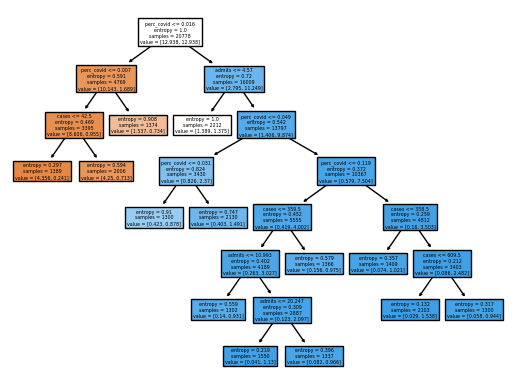

In [51]:
plot_tree(clf_exact, feature_names=['cases', 'admits','perc_covid'], filled=True)


Classifiers by week 

In [414]:
weeks_to_predict = range(1,121)
ROC_by_week = []
sensitivity_by_week = []
specificity_by_week = []
ppv_by_week = []
npv_by_week = []
accuracy_by_week = []

#
for prediction_week in weeks_to_predict: 
    
    X_train_CDC_exact, y_train_CDC_exact, weights_CDC_exact, missing_data_train_HSA = prep_training_test_data(CDC_data,  no_weeks = range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

    X_test_CDC_exact, y_test_CDC_exact, weights_test_CDC_exact, missing_data_test_HSA = prep_training_test_data(CDC_data,  no_weeks = range(int(prediction_week + 26) + 1, int(prediction_week +26 + 13) + 1), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
    weights_CDC_exact = weights_CDC_exact[0].to_numpy()
    best_params = cross_validation_leave_geo_out(CDC_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf_exact, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,
        no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)
    clf_exact = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_exact.fit(X_train_CDC_exact, y_train_CDC_exact,  sample_weight = weights_CDC_exact)

    # Make predictions on the test set
    y_pred = clf_exact.predict(X_test_CDC_exact)
    y_pred_proba = clf_exact.predict_proba(X_test_CDC_exact)


    # Evaluate the accuracy of the model
    accuracy_by_week.append(accuracy_score(y_test_CDC_exact, y_pred))
    ROC_by_week.append(roc_auc_score(y_test_CDC_exact, y_pred_proba[:,1]))
    conf_matrix = confusion_matrix(y_test_CDC_exact, y_pred)

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    # Calculate specificity (true negative rate)
    specificity_by_week.append(TN / (TN + FP))
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week.append(TP / (TP + FN))

    ppv, npv = calculate_ppv_npv(conf_matrix)
    ppv_by_week.append(ppv)
    npv_by_week.append(npv)

NameError: name 'CDC_data' is not defined

In [12]:

def calculate_metrics(confusion_matrix):
    # Extract values from the confusion matrix
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    TN = confusion_matrix[0, 0]
    FN = confusion_matrix[1, 0]

    # Calculate Sensitivity (True Positive Rate), Specificity (True Negative Rate),
    # PPV (Precision), and NPV
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0.0

    return sensitivity, specificity, ppv, npv

# Full classifier 

In [9]:
new_directory = '/Users/rem76/Documents/COVID_projections/Two_month_models/'
os.chdir(new_directory)

In [13]:
clf_full_period = DecisionTreeClassifier(random_state=10, class_weight='balanced')

In [10]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(10) + 1)  # First 6 months initially 
no_weeks_test = range(26, int(26 + 13) + 1)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 50  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

Develop classifiers

In [22]:
weeks_to_predict = range(1, 121 - 5 - 3 - 10)
ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []

for prediction_week in weeks_to_predict:
    print(prediction_week)
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=no_weeks_train, weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=no_weeks_test, weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(HSA_weekly_data_all, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf_full_period, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')
    clf_full_period = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period.append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    model_name_to_save = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    pickle.dump(clf_full_period, open(model_name_to_save, 'wb'))
    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(sensitvity)

    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


Get metrics

In [13]:
weeks_to_predict = range(1, 121 - 13 - 3 - 26)
ROC_by_week_full_period = []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []

for prediction_week in weeks_to_predict:
    print(prediction_week)
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_full_period, y_pred))
    ROC_by_week_full_period.append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)


    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_full_period.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(sensitvity)

    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


Gtet best and worst classifiers

In [14]:
max_index = ROC_by_week_full_period.index(max(ROC_by_week_full_period))
best_model_week = max_index - 1
print(best_model_week)
print(ROC_by_week_full_period[max_index])
# Find the index of the minimum value
min_index = ROC_by_week_full_period.index(min(ROC_by_week_full_period))
worst_model_week = min_index - 1
print(worst_model_week)
print(ROC_by_week_full_period[min_index])


26
0.9599873106250087
56
0.7516262348483463


In [417]:
Best_model = "Full_model_" + time_period + "_" + str(best_model_week) + ".sav"
Worst_model = "Full_model_" + time_period + "_" + str(worst_model_week) + ".sav"

clf_full_period_best = pickle.load(open(Best_model, 'rb'))
clf_full_period_worst = pickle.load(open(Worst_model, 'rb'))

Best_model = "Full_model_" + time_period +  "_best_model_" + ".sav"
Worst_model = "Full_model_" + time_period + "_worst_model_" + ".sav"
pickle.dump(clf_full_period_best, open(Best_model, 'wb'))
pickle.dump(clf_full_period_worst, open(Worst_model, 'wb'))

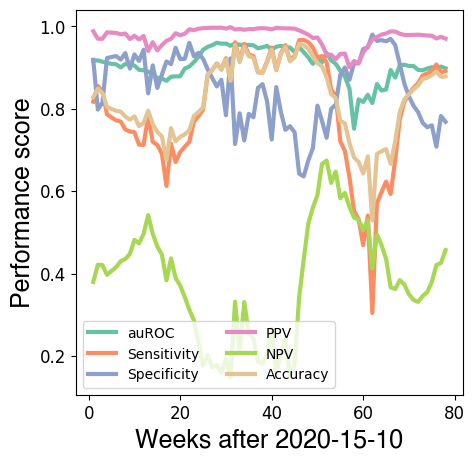

In [15]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Plot data on the same plot
axs.plot(weeks_to_predict, ROC_by_week_full_period, label='auROC', linewidth=3, color = palette[0])
axs.plot(weeks_to_predict, sensitivity_by_week_full_period, label='Sensitivity', linewidth=3, color = palette[1])
axs.plot(weeks_to_predict, specificity_by_week_full_period, label='Specificity', linewidth=3, color = palette[2])
axs.plot(weeks_to_predict, ppv_by_week_full_period, label='PPV', linewidth=3, color = palette[3])
axs.plot(weeks_to_predict, npv_by_week_full_period, label='NPV', linewidth=3, color = palette[4])
axs.plot(weeks_to_predict, accuracy_by_week_full_period, label='Accuracy', linewidth=3, color = palette[5])


# Add labels and legend
axs.set_xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18 )
axs.set_xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18 )

axs.set_ylabel('Performance score',**hfont,  fontsize = 18)
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='major', labelsize=12)
axs.legend(ncol = 2, loc='lower left')
plt.savefig('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_full_6_month_models_period.png', dpi = 300)


Find important features for these classifiers

In [17]:

# Number of iterations and features
feature_names=feature_names=['Cases','\u0394 Cases', 'Deaths', '\u0394 Deaths', 'Admissions', '\u0394 Admissions', 'ICU', '\u0394 ICU',  'Beds', '\u0394 Beds', 'Percent of beds', '\u0394 Perc. beds', 'Hospital capacity exceeded']
num_features = len(feature_names)

# Initialize a dictionary to store feature importance counts
feature_importance_counts = {feature_name: 0 for feature_name in feature_names}

# Loop through iterations
for prediction_week in weeks_to_predict:
    # Create the training data
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    weights_full_period = weights_full_period[0].to_numpy()
    
    # Load and train the model 
    model_name = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

    clf_full_period = pickle.load(open(model_name, 'rb'))
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Get feature importances for this iteration
    feature_importances = clf_full_period.feature_importances_
    
    # Update the counts for each feature
    for feature_idx, importance in enumerate(feature_importances):
        if importance > 0:
            feature_name = feature_names[feature_idx]
            feature_importance_counts[feature_name] += 1



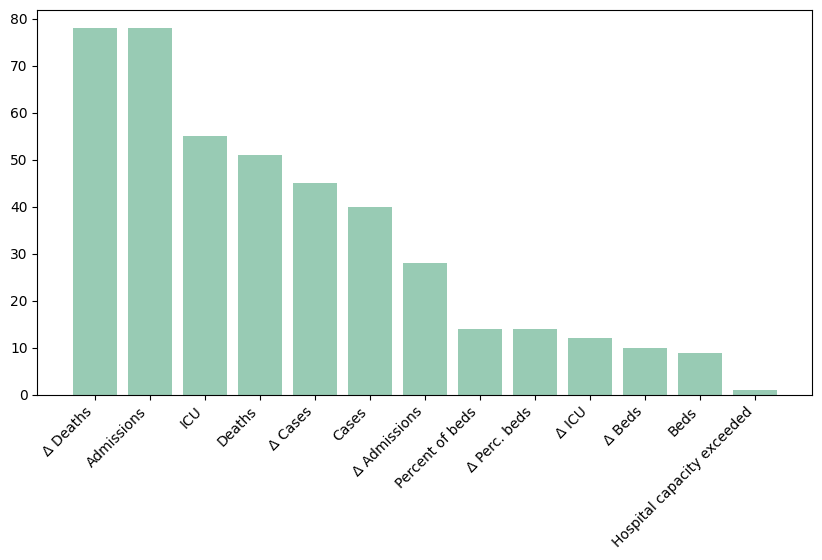

In [18]:
fig, axs = plt.subplots(1,1, figsize=(10, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

sorted_feature_importance_counts = dict(sorted(feature_importance_counts.items(), key=lambda item: item[1], reverse=True))

plt.bar(sorted_feature_importance_counts.keys(), sorted_feature_importance_counts.values(), color = '#98CBB4')

plt.xticks(rotation=45, ha='right')

plt.savefig('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Included_features_6_month_full_period.png', dpi = 300)


# Naive classifier 

In [19]:
weeks_to_predict = range(1, 121 - 13 - 3 - 26)
ROC_by_week_naive_period = []
sensitivity_by_week_naive_period = []
specificity_by_week_naive_period = []
ppv_by_week_naive_period = []
npv_by_week_naive_period = []
accuracy_by_week_naive_period = []

ROC_by_week_naive_exact = []
sensitivity_by_week_naive_exact = []
specificity_by_week_naive_exact = []
ppv_by_week_naive_exact = []
npv_by_week_naive_exact = []
accuracy_by_week_naive_exact = []

ROC_by_week_naive_shifted = []
sensitivity_by_week_naive_shifted = []
specificity_by_week_naive_shifted = []
ppv_by_week_naive_shifted = []
npv_by_week_naive_shifted = []
accuracy_by_week_naive_shifted = []

for prediction_week in weeks_to_predict:
    print(prediction_week)

    #period
    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(naive_data, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(naive_data, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as is the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_period.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_period.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_period.append(sensitvity)
    specificity_by_week_naive_period.append(specificity)

    ppv_by_week_naive_period.append(ppv)
    npv_by_week_naive_period.append(npv)

    #exact 
    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_exact.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_exact.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_exact.append(sensitivity)
    specificity_by_week_naive_exact.append(specificity)

    ppv_by_week_naive_exact.append(ppv)
    npv_by_week_naive_exact.append(npv)

    X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive_shifted, y_test_naive_shifted, weights_test_naive_shifted, missing_data_test_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive_shifted = weights_naive_shifted[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_shifted)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_shifted)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_shifted.append(accuracy_score(y_test_naive_shifted, y_pred))
    ROC_by_week_naive_shifted.append(roc_auc_score(y_test_naive_shifted, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive_shifted, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_shifted.append(sensitivity)
    specificity_by_week_naive_shifted.append(specificity)

    ppv_by_week_naive_shifted.append(ppv)
    npv_by_week_naive_shifted.append(npv)

    

1
['_three_']
['_three_', '_four_']
['_three_', '_four_', '_five_']
['_four_']
['_four_', '_five_']
['_four_', '_five_', '_six_']
['_five_']
['_five_', '_six_']
['_five_', '_six_', '_seven_']
['_six_']
['_six_', '_seven_']
['_six_', '_seven_', '_eight_']
['_seven_']
['_seven_', '_eight_']
['_seven_', '_eight_', '_nine_']
['_eight_']
['_eight_', '_nine_']
['_eight_', '_nine_', '_ten_']
['_nine_']
['_nine_', '_ten_']
['_nine_', '_ten_', '_eleven_']
['_ten_']
['_ten_', '_eleven_']
['_ten_', '_eleven_', '_twelve_']
['_eleven_']
['_eleven_', '_twelve_']
['_eleven_', '_twelve_', '_thirteen_']
['_twelve_']
['_twelve_', '_thirteen_']
['_twelve_', '_thirteen_', '_fourteen_']
['_thirteen_']
['_thirteen_', '_fourteen_']
['_thirteen_', '_fourteen_', '_fifteen_']
['_fourteen_']
['_fourteen_', '_fifteen_']
['_fourteen_', '_fifteen_', '_sixteen_']
['_fifteen_']
['_fifteen_', '_sixteen_']
['_fifteen_', '_sixteen_', '_seventeen_']
['_sixteen_']
['_sixteen_', '_seventeen_']
['_sixteen_', '_seventeen_', 

In [20]:
import string
def add_labels_to_subplots(axs, hfont, height, fontsize):
    labels_subplots = list(string.ascii_uppercase)
    for i, ax in enumerate(axs):
        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[1] * height,
            labels_subplots[i],
            fontsize=fontsize,
            **hfont,
        )
    return labels_subplots

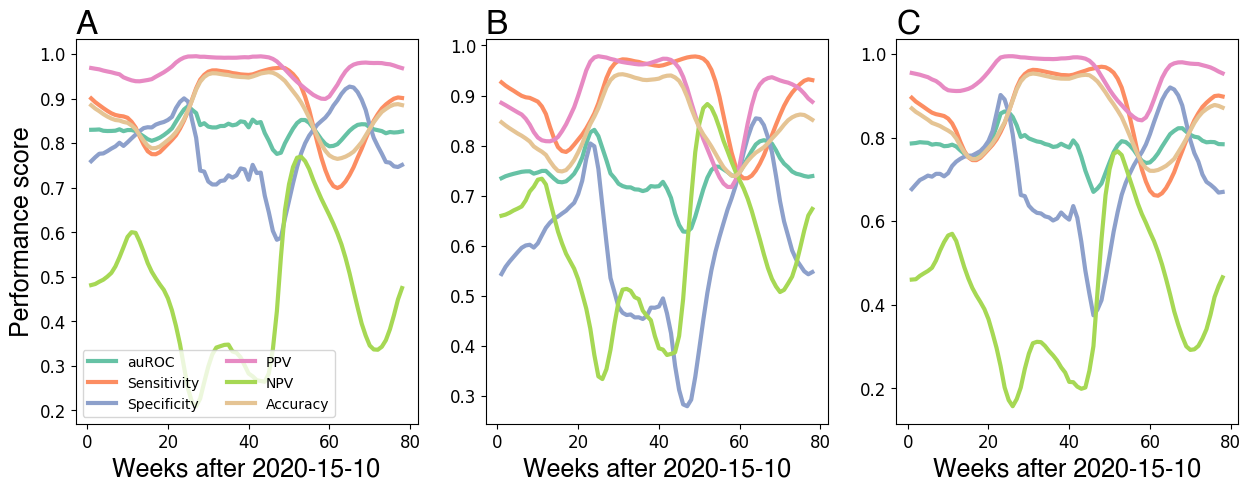

In [21]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_period, label='auROC', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict, sensitivity_by_week_naive_period, label='Sensitivity', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict, specificity_by_week_naive_period, label='Specificity', linewidth = 3, color = palette[2])
axs[0].plot(weeks_to_predict, ppv_by_week_naive_period, label='PPV', linewidth = 3, color = palette[3])
axs[0].plot(weeks_to_predict, npv_by_week_naive_period, label='NPV', linewidth = 3, color = palette[4])
axs[0].plot(weeks_to_predict, accuracy_by_week_naive_period, label='Accuracy', linewidth = 3, color = palette[5])

# Plot data on the same plot
axs[1].plot(weeks_to_predict, ROC_by_week_naive_exact, label='auROC', linewidth = 3, color = palette[0])
axs[1].plot(weeks_to_predict, sensitivity_by_week_naive_exact, label='Sensitivity', linewidth = 3, color = palette[1])
axs[1].plot(weeks_to_predict, specificity_by_week_naive_exact, label='Specificity', linewidth = 3, color = palette[2])
axs[1].plot(weeks_to_predict, ppv_by_week_naive_exact, label='PPV', linewidth = 3, color = palette[3])
axs[1].plot(weeks_to_predict, npv_by_week_naive_exact, label='NPV', linewidth = 3, color = palette[4])
axs[1].plot(weeks_to_predict, accuracy_by_week_naive_exact, label='Accuracy', linewidth = 3, color = palette[5])

axs[2].plot(weeks_to_predict, ROC_by_week_naive_shifted, label='auROC', linewidth=3, color=palette[0])
axs[2].plot(weeks_to_predict, sensitivity_by_week_naive_shifted, label='Sensitivity', linewidth=3, color=palette[1])
axs[2].plot(weeks_to_predict, specificity_by_week_naive_shifted, label='Specificity', linewidth=3, color=palette[2])
axs[2].plot(weeks_to_predict, ppv_by_week_naive_shifted, label='PPV', linewidth=3, color=palette[3])
axs[2].plot(weeks_to_predict, npv_by_week_naive_shifted, label='NPV', linewidth=3, color=palette[4])
axs[2].plot(weeks_to_predict, accuracy_by_week_naive_shifted, label='Accuracy', linewidth=3, color=palette[5])

# Add labels and legend
axs[0].set_xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18 )
axs[1].set_xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18 )
axs[2].set_xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18 )

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')
plt.savefig('/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_naive_2_month_models_period_exact.png', dpi = 300)


# CDC Classifier A 

In [246]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(10) + 1)  # First 6 months initially 
no_weeks_test = range(26, int(26 + 13) + 1)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  
no_iterations_param = 10  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 20, 2),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [250]:
weeks_to_predict = range(1, 121 - 13 - 3 - 26)
ROC_by_week_CDC_A_exact = []
sensitivity_by_week_CDC_A_exact = []
specificity_by_week_CDC_A_exact = []
ppv_by_week_CDC_A_exact = []
npv_by_week_CDC_A_exact = []
accuracy_by_week_CDC_A_exact = []
clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')
for prediction_week in weeks_to_predict:
    print(prediction_week)
    X_train_CDC_A_exact, y_train_CDC_A_exact, weights_CDC_A_exact, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_CDC_A_exact, y_test_CDC_A_exact, weights_test_CDC_A_exact, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_CDC_A_exact = weights_CDC_A_exact[0].to_numpy()
    best_params = cross_validation_leave_geo_out(HSA_weekly_data_all, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period=time_period)
    clf_CDC_A_exact = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_CDC_A_exact.fit(X_train_CDC_A_exact, y_train_CDC_A_exact, sample_weight=weights_CDC_A_exact)

    # Make predictions on the test set
    y_pred = clf_CDC_A_exact.predict(X_test_CDC_A_exact)
    y_pred_proba = clf_CDC_A_exact.predict_proba(X_test_CDC_A_exact)

    # Evaluate the accuracy of the model
    accuracy_by_week_CDC_A_exact.append(accuracy_score(y_test_CDC_A_exact, y_pred))
    ROC_by_week_CDC_A_exact.append(roc_auc_score(y_test_CDC_A_exact, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_CDC_A_exact, y_pred)

    model_name_to_save = "CDC_A_model_" + time_period + "_" + str(prediction_week) + ".sav"

    pickle.dump(clf_CDC_A_exact, open(model_name_to_save, 'wb'))
    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    specificity_by_week_CDC_A_exact.append(specificity)
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_CDC_A_exact.append(sensitvity)

    ppv_by_week_CDC_A_exact.append(ppv)
    npv_by_week_CDC_A_exact.append(npv)


1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

# LOOCV on "Full" model 6 month period 

In [374]:
testing_dataframe['week_one hundred and twenty-one_beds']

0    30.334604
Name: week_one hundred and twenty-one_beds, dtype: float64

In [376]:
testing_dataframe['week_one hundred and twenty-two_beds']

0    14.507854
Name: week_one hundred and twenty-two_beds, dtype: float64

In [379]:
testing_dataframe['week_one hundred and twenty-two_beds_delta']

0   NaN
Name: week_one hundred and twenty-two_beds_delta, dtype: float64

In [364]:
weeks_to_predict = range(1, 121 - 13 - 3 - 26)
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'

ROC_by_HSA_full = {}
accuracy_by_HSA_full = {}
sensitivity_by_HSA_full = {}
specificity_by_HSA_full = {}
ppv_by_HSA_full = {}
npv_by_HSA_full = {}


for prediction_week in weeks_to_predict:
    print(prediction_week)
    ROC_by_week_full = {}
    sensitivity_by_week_full = {}
    specificity_by_week_full = {}
    ppv_by_week_full = {}
    npv_by_week_full = {}
    accuracy_by_week_full = {}
    for HSA in HSA_weekly_data_all['HSA_ID'].unique():
        training_dataframe, testing_dataframe = LOOCV_by_HSA_dataset(HSA_weekly_data_all, HSA, 'HSA_ID')
        if not testing_dataframe['weight'].isna().any():
            X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(training_dataframe, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

            X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(testing_dataframe, no_weeks=range(int(prediction_week + 26) + 1 , int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        
            weights_full = weights_full[0].to_numpy()
            model_name = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"

            clf_full_period = pickle.load(open(model_name, 'rb'))
            clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)
            clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

            # Make predictions on the test set
            y_pred = clf_full_period.predict(X_test_full)
            y_pred_proba = clf_full_period.predict_proba(X_test_full)

            # Evaluate the predictive power of the model
            conf_matrix = confusion_matrix(y_test_full, y_pred)

            accuracy_by_week_full[HSA] = accuracy_score(y_test_full, y_pred)
            if (sum(y_test_full[0]) == len(y_test_full[0])) | (sum(y_test_full[0]) == 0):
                ROC_by_week_full[HSA] = None
                specificity_by_week_full[HSA] = None
                sensitivity_by_week_full[HSA] = None
                ppv_by_week_full[HSA] = None
                npv_by_week_full[HSA] = None
            else:
                ROC_by_week_full[HSA] = roc_auc_score(y_test_full, y_pred_proba[:, 1])
                sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
                specificity_by_week_full[HSA] = specificity
                sensitivity_by_week_full[HSA] =sensitvity
                ppv_by_week_full[HSA] = ppv
                npv_by_week_full[HSA] = npv



    save_in_HSA_dictionary(prediction_week, ROC_by_week_full ,accuracy_by_week_full, sensitivity_by_week_full, specificity_by_week_full, ppv_by_week_full, npv_by_week_full, ROC_by_HSA_full, accuracy_by_HSA_full, sensitivity_by_HSA_full, specificity_by_HSA_full, ppv_by_HSA_full, npv_by_HSA_full )

1


ValueError: Found array with 0 sample(s) (shape=(0, 13)) while a minimum of 1 is required by DecisionTreeClassifier.

# LOOCV on "Naive" model 6 month period

In [25]:
def LOOCV_by_HSA_dataset(dataframe, geo_ID, geo_ID_col):
    training_dataframe = dataframe[dataframe[geo_ID_col] != geo_ID]
    testing_dataframe = dataframe[dataframe[geo_ID_col] == geo_ID]
    return training_dataframe, testing_dataframe
    

In [10]:
def save_in_HSA_dictionary(prediction_week, ROC_by_week,accuracy_by_week,  sensitivity_by_week,specificity_by_week, ppv_by_week, npv_by_week, ROC_by_HSA, accuracy_by_HSA, sensitivity_by_HSA, specificity_by_HSA, ppv_by_HSA, npv_by_HSA ):
    ROC_by_HSA[prediction_week] = ROC_by_week
    accuracy_by_HSA[prediction_week] = accuracy_by_week
    sensitivity_by_HSA[prediction_week] = sensitivity_by_week
    specificity_by_HSA[prediction_week] = specificity_by_week
    ppv_by_HSA[prediction_week] = ppv_by_week
    npv_by_HSA[prediction_week] = npv_by_week



In [199]:
weeks_to_predict = range(1, 121 - 13 - 3 - 26)

ROC_by_HSA_naive = {}
accuracy_by_HSA_naive = {}
sensitivity_by_HSA_naive = {}
specificity_by_HSA_naive = {}
ppv_by_HSA_naive = {}
npv_by_HSA_naive = {}


for prediction_week in weeks_to_predict:
    print(prediction_week)
    ROC_by_week_naive = {}
    sensitivity_by_week_naive = {}
    specificity_by_week_naive = {}
    ppv_by_week_naive = {}
    npv_by_week_naive = {}
    accuracy_by_week_naive = {}
    for HSA in naive_data['HSA_ID'].unique():
        training_dataframe, testing_dataframe = LOOCV_by_HSA_dataset(naive_data, HSA, 'HSA_ID')
        if not testing_dataframe['weight'].isna().any():
            X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(training_dataframe, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

            X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(testing_dataframe, no_weeks=range(int(prediction_week + 26) + 1 , int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        
            weights_naive = weights_naive[0].to_numpy()
            # no hyperparameter tuning as is the same irrespective of hyperparameters
            clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
            clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

            # Make predictions on the test set
            y_pred = clf_naive.predict(X_test_naive)
            y_pred_proba = clf_naive.predict_proba(X_test_naive)

            # Evaluate the predictive power of the model
            conf_matrix = confusion_matrix(y_test_naive, y_pred)

            accuracy_by_week_naive[HSA] = accuracy_score(y_test_naive, y_pred)
            if (sum(y_test_naive[0]) == len(y_test_naive[0])) | (sum(y_test_naive[0]) == 0):
                ROC_by_week_naive[HSA] = None
                specificity_by_week_naive[HSA] = None
                sensitivity_by_week_naive[HSA] = None
                ppv_by_week_naive[HSA] = None
                npv_by_week_naive[HSA] = None
            else:
                ROC_by_week_naive[HSA] = roc_auc_score(y_test_naive, y_pred_proba[:, 1])
                sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
                specificity_by_week_naive[HSA] = specificity
                sensitivity_by_week_naive[HSA] =sensitvity
                ppv_by_week_naive[HSA] = ppv
                npv_by_week_naive[HSA] = npv



    save_in_HSA_dictionary(prediction_week, ROC_by_week_naive ,accuracy_by_week_naive, sensitivity_by_week_naive, specificity_by_week_naive, ppv_by_week_naive, npv_by_week_naive, ROC_by_HSA_naive, accuracy_by_HSA_naive, sensitivity_by_HSA_naive, specificity_by_HSA_naive, ppv_by_HSA_naive, npv_by_HSA_naive )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


In [251]:
pickle.dump(accuracy_by_HSA_naive, open('accuracy_by_HSA_naive', 'wb'))
pickle.dump(npv_by_week_naive, open('npv_by_week_naive', 'wb'))
pickle.dump(ppv_by_week_naive, open('ppv_by_week_naive', 'wb'))
pickle.dump(sensitivity_by_week_naive, open('sensitivity_by_week_naive', 'wb'))
pickle.dump(specificity_by_week_naive, open('specificity_by_week_naive', 'wb'))
pickle.dump(ROC_by_week_naive, open('ROC_by_week_naive', 'wb'))


In [360]:
ALL_METRICS_NAIVE = [ROC_by_HSA_naive, accuracy_by_HSA_naive, sensitivity_by_HSA_naive, specificity_by_HSA_naive, ppv_by_HSA_naive, npv_by_HSA_naive]
ylabels = ['auROC', 'Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV']
labels_subplots = ['A', 'B', 'C', 'D', 'E', 'F']

boxplots

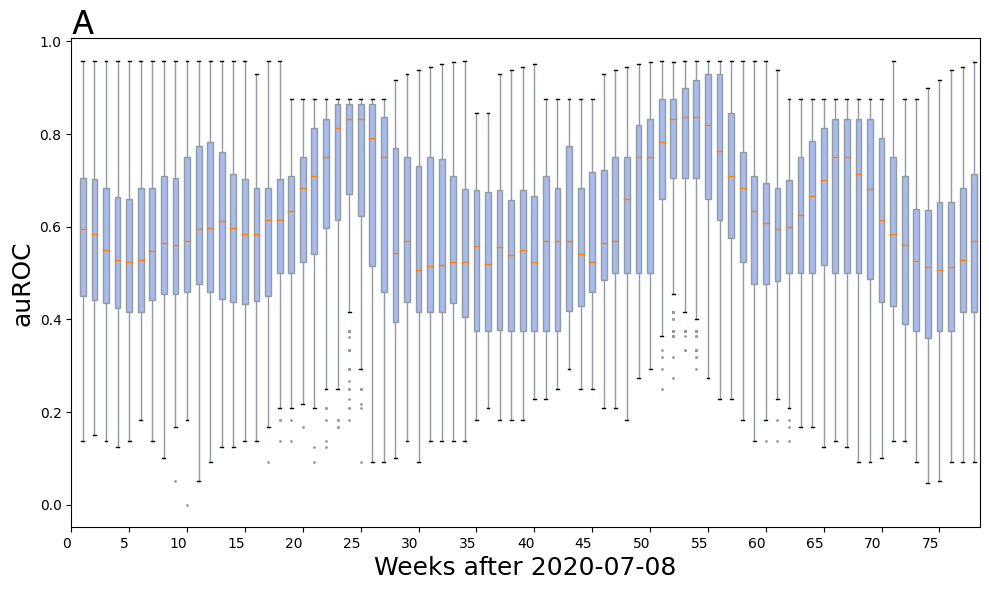

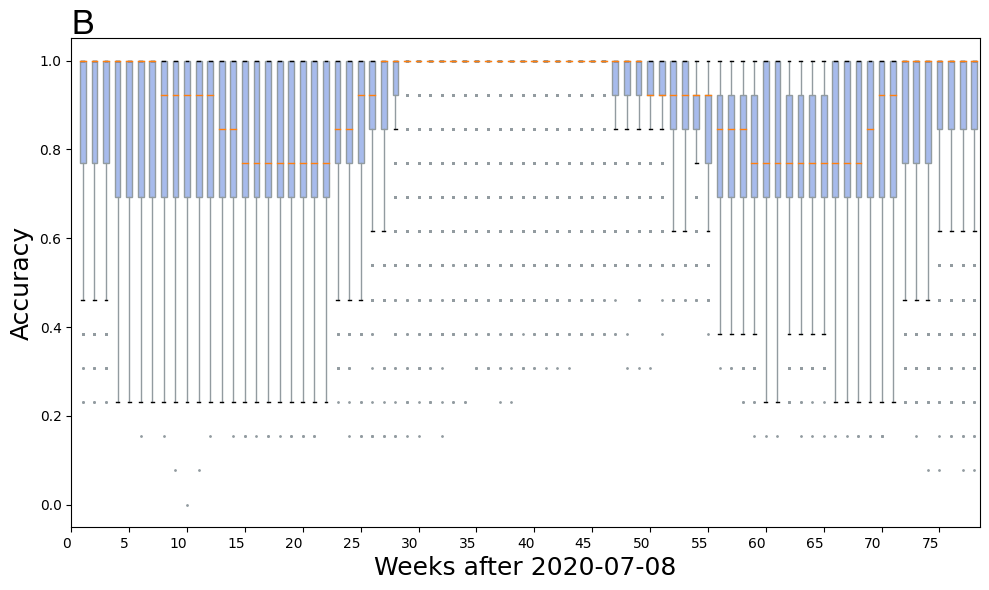

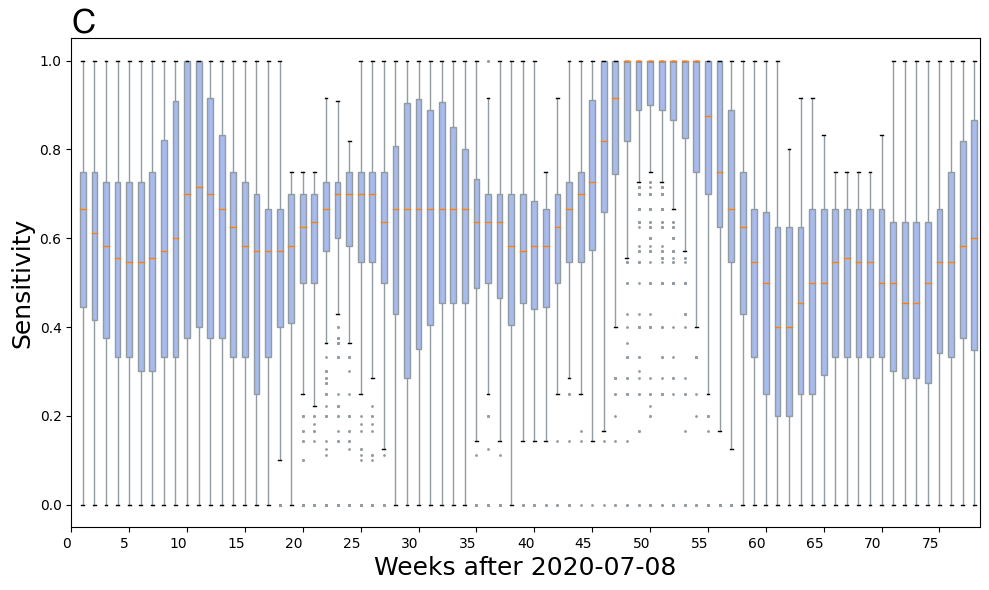

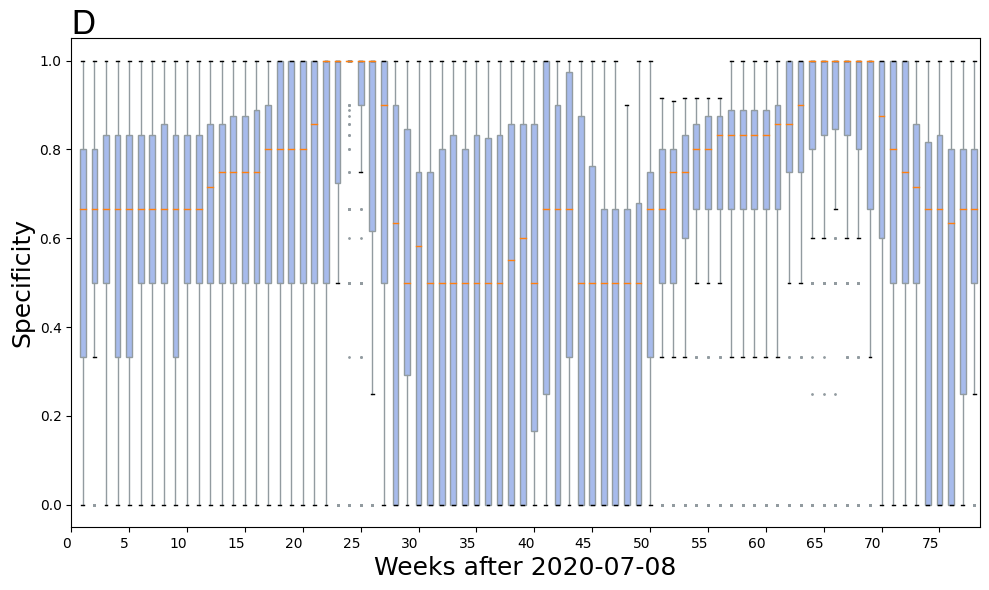

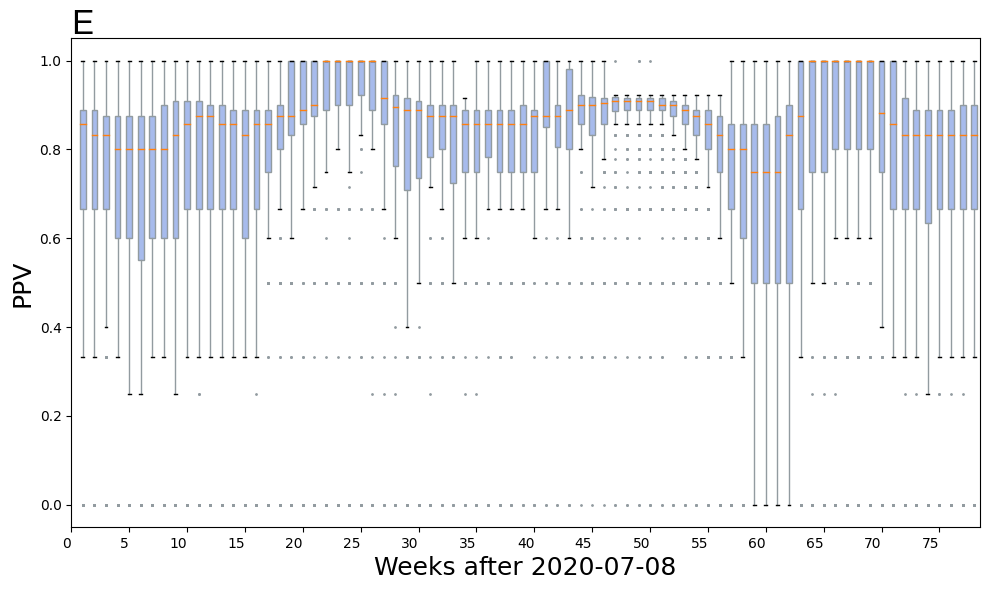

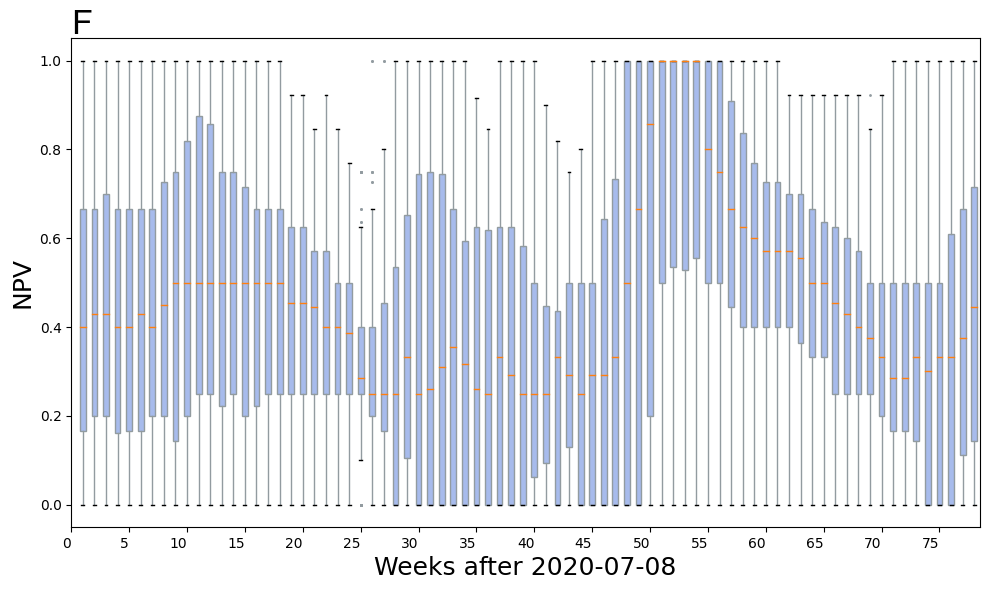

In [362]:
for j, metric in enumerate(ALL_METRICS_NAIVE):
    fig, axs = plt.subplots(figsize=(10, 6), facecolor='w', edgecolor='k')

    all_values = []
    labels = []
    labels_ticks = [0]
    for i, prediction_week in enumerate(weeks_to_predict):
        values = metric[prediction_week].values()
        values = [float(value) for value in values if value != 'NA' and value is not None]  # Convert and filter
        
        if values:
            all_values.append(values)
            labels.append(f'Week {prediction_week}')
        if prediction_week % 5 == 0:  # Label every 5th week
                labels_ticks.append(f'{prediction_week}')
        
    # Create a combined violin and box plot
    whisker_props = dict(linewidth=1, color='#929BA0')
    box_props = dict(facecolor='#A7BBEC', edgecolor='#929BA0')
    outlier_props = dict(marker='.', markersize=2, markerfacecolor='#929BA0', markeredgecolor='#929BA0')

    axs.boxplot(all_values, labels=labels, showfliers=True, patch_artist=True,boxprops=box_props, whiskerprops=whisker_props, flierprops = outlier_props)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Set ticks only for every 5th week
    axs.set_xticks(np.arange(0, 80, step=5))
    axs.set_xticklabels(labels_ticks, rotation=0)

    # Add labels and title
    plt.xlabel('Weeks after 2020-07-08', fontsize=18)
    plt.ylabel(ylabels[j], fontsize=18)
    axs.text(
            axs.get_xlim()[0],
            axs.get_ylim()[1] * 1.01,
            labels_subplots[j],
            fontsize=24,
            **hfont,
        )
    plt.tight_layout()
    graph_name = '/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/' + 'Performance_naive_6_month_models_period_' + ylabels[j] +  '.png'
    plt.savefig(graph_name, dpi = 300)


 violin plots

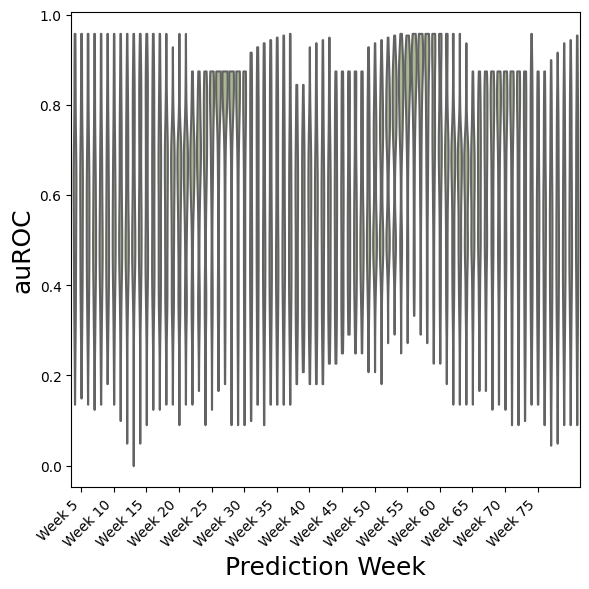

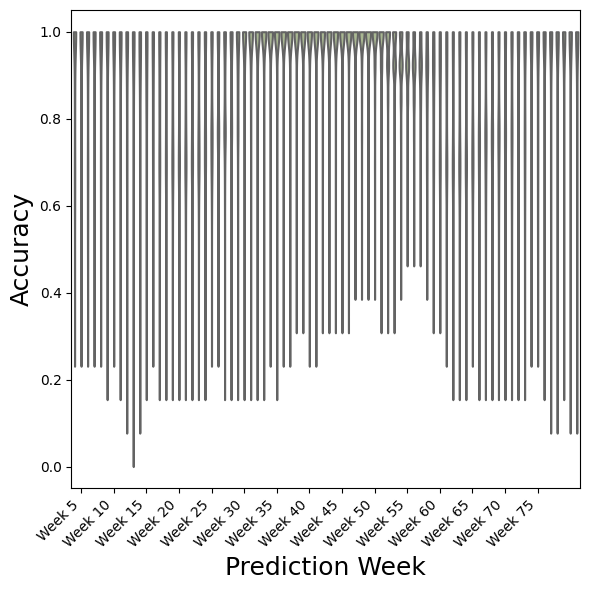

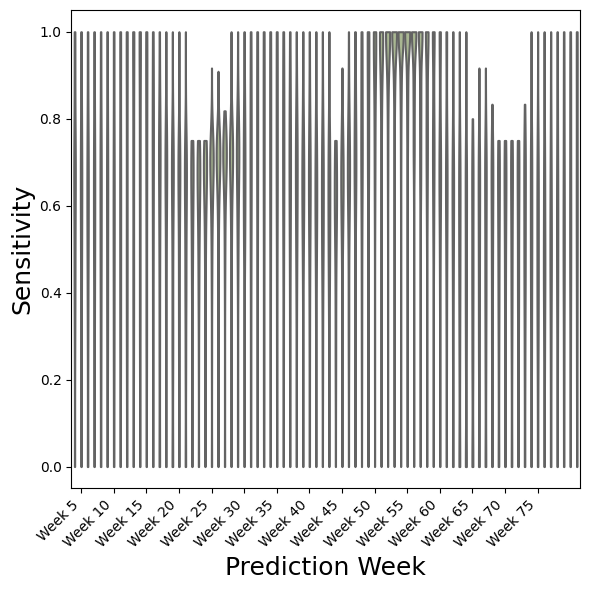

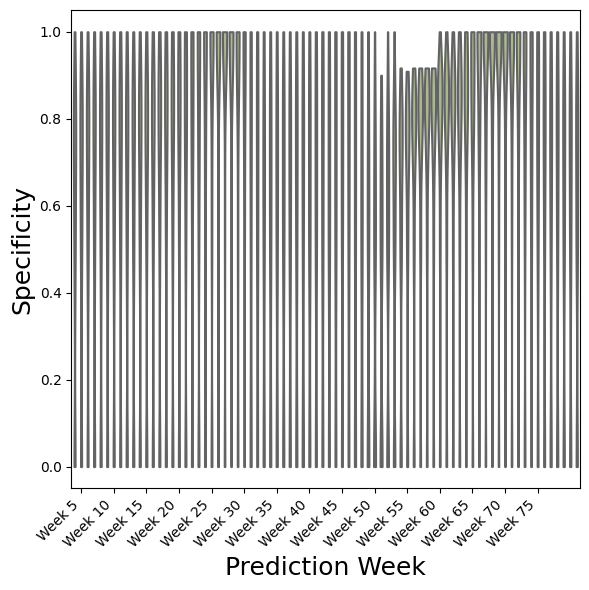

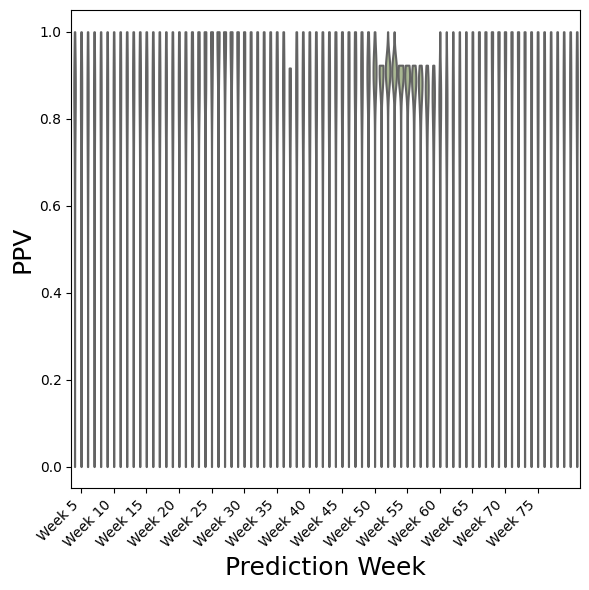

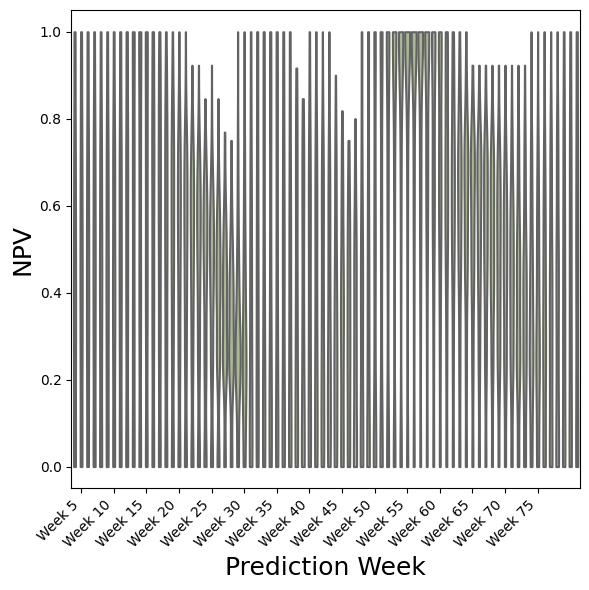

In [325]:
for j, metric in enumerate(ALL_METRICS_NAIVE):
    fig, axs = plt.subplots(figsize=(6, 6), facecolor='w', edgecolor='k')

    all_values = []
    labels = []
    labels_ticks = []
    for i, prediction_week in enumerate(weeks_to_predict):
        values = metric[prediction_week].values()
        values = [float(value) for value in values if value != 'NA' and value is not None]  # Convert and filter
        
        if values:
            all_values.extend(values)  # Flatten the list for the plot
            labels.extend([f'Week {prediction_week}'] * len(values))
        if prediction_week % 5 == 0:  # Label every 5th week
                labels_ticks.append(f'Week {prediction_week}')
        
    # Create a combined violin and box plot
    sns.violinplot(x=labels, y=all_values, side='right', inner = None, color='#A7BBEC', cut=0)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Set ticks only for every 5th week
    axs.set_xticks(np.arange(1, 76, step=5))
    axs.set_xticklabels(labels_ticks, rotation=45, ha='right')

    # Add labels and title
    plt.xlabel('Prediction Week', fontsize=18)
    plt.ylabel(ylabels[j], fontsize=18)

    plt.tight_layout()
    plt.show()


dots

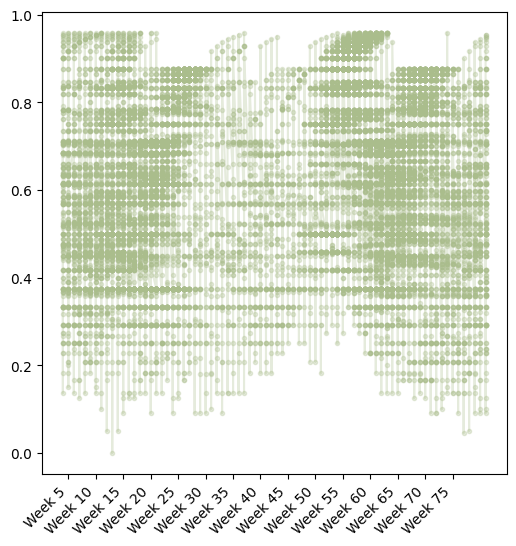

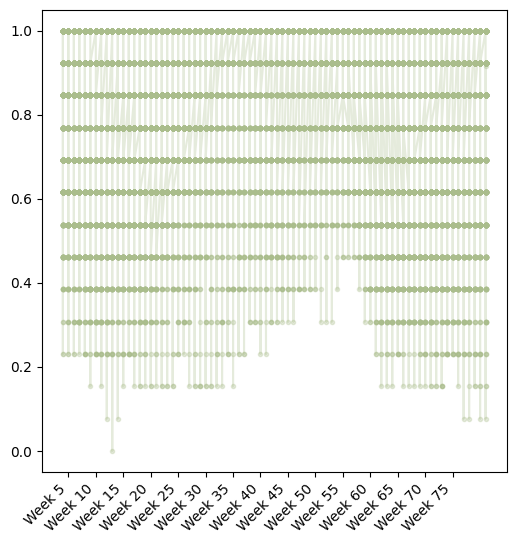

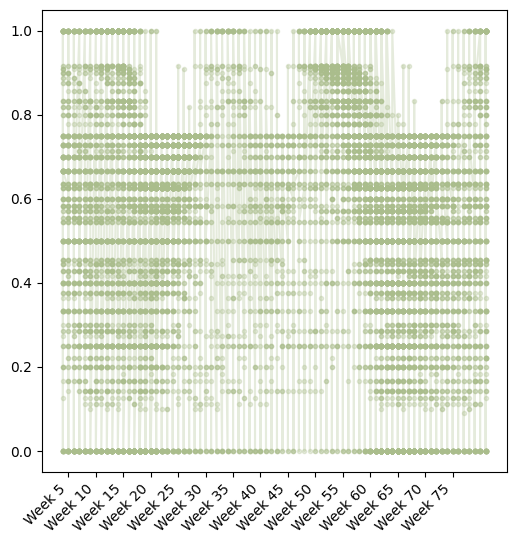

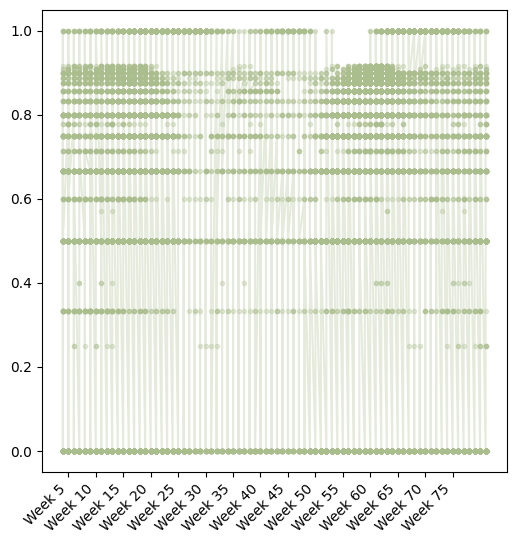

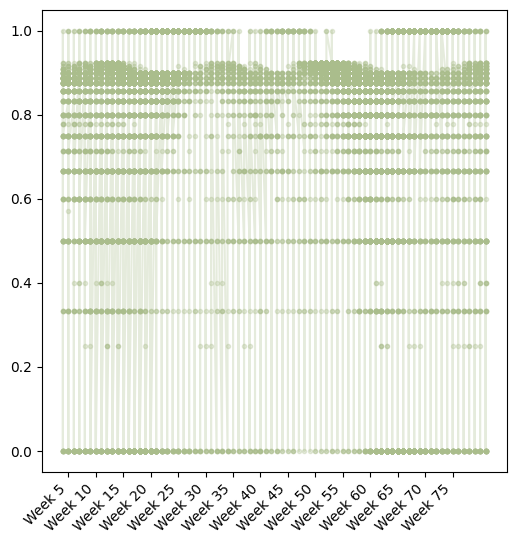

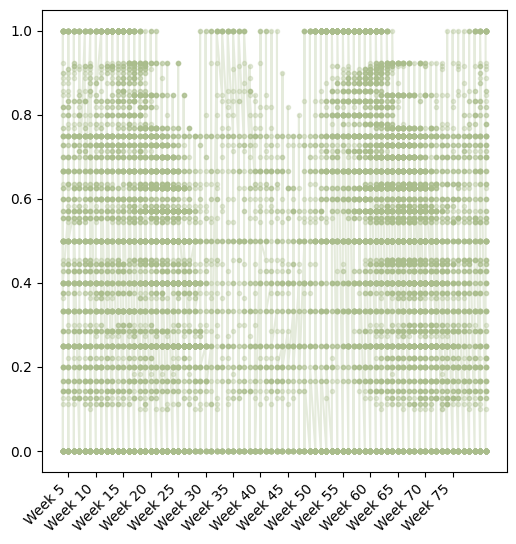

In [329]:
for j, metric in enumerate(ALL_METRICS_NAIVE):
    fig, axs = plt.subplots(figsize=(6, 6), facecolor='w', edgecolor='k')

    all_values = []
    labels = []
    labels_ticks = []
    for i, prediction_week in enumerate(weeks_to_predict):
        values = metric[prediction_week].values()
        values = [float(value) for value in values if value != 'NA' and value is not None]  # Convert and filter
        
        if values:
            all_values.extend(values)  # Flatten the list for the plot
            labels.extend([f'Week {prediction_week}'] * len(values))
        if prediction_week % 5 == 0:  # Label every 5th week
                labels_ticks.append(f'Week {prediction_week}')
        
    # Create a combined violin and box plot
    plt.plot(labels, all_values,color='#A7BBEC', marker = '.', alpha = 0.3)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Set ticks only for every 5th week
    axs.set_xticks(np.arange(1, 76, step=5))
    axs.set_xticklabels(labels_ticks, rotation=45, ha='right')

# Check specific weeks

In [404]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(10) + 1)  # First 10 weeks initially 
no_weeks_test = range(26, int(10 + 5) + 1)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 50  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [406]:
weeks_to_predict = [60]


for prediction_week in weeks_to_predict:
    print(prediction_week)
    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(HSA_weekly_data_all, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf_full_period, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')
    clf_full_period = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model
    accuracy = (accuracy_score(y_test_full_period, y_pred))
    ROC = roc_auc_score(y_test_full_period, y_pred_proba[:, 1])
    conf_matrix = confusion_matrix(y_test_full_period, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)


60


In [407]:
ROC

0.7399219682933165

In [411]:
ROC_by_week_full_period[61] = ROC